In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
#r = pd.read_csv( 'ratings.csv' )
#tr = pd.read_csv( 'to_read.csv' )
b = pd.read_csv( 'books.csv' )
t = pd.read_csv( 'tags.csv' )
bt = pd.read_csv( 'book_tags.csv' )

# Data

### Books

In [3]:
b.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')

Books are sorted by their popularity, as measured by number of ratings (overall, not in this dataset).

In [4]:
len(b)

10000

In [5]:
b.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')

### Tags

In [6]:
t.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [7]:
len(t)

34252

In [8]:
bt.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


Tag applications are sorted by goodreads_book_id ASC and by count DESC.

In [9]:
len(bt)

999912

# Merge Datasets

In [10]:
bt = bt.merge(t, on = 'tag_id')

In [11]:
bt.head()

,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
1,2,30574,24549,to-read
2,3,30574,496107,to-read
3,5,30574,11909,to-read
4,6,30574,298,to-read


Why don't we merge book titles for good measure.

In [12]:
bt = bt.merge(b[['goodreads_book_id', 'title', 'average_rating']], on='goodreads_book_id')

In [13]:
bt.head()

,goodreads_book_id,tag_id,count,tag_name,title,average_rating
0,1,30574,167697,to-read,Harry Potter and the Half-Blood Prince (Harry ...,4.54
1,1,11305,37174,fantasy,Harry Potter and the Half-Blood Prince (Harry ...,4.54
2,1,11557,34173,favorites,Harry Potter and the Half-Blood Prince (Harry ...,4.54
3,1,8717,12986,currently-reading,Harry Potter and the Half-Blood Prince (Harry ...,4.54
4,1,33114,12716,young-adult,Harry Potter and the Half-Blood Prince (Harry ...,4.54


# EDA

It appears that there are some negative tag counts. Let's fix this.

In [14]:
bt['count'].describe()

count    999912.000000
mean        208.869633
std        3501.265173
min          -1.000000
25%           7.000000
50%          15.000000
75%          40.000000
max      596234.000000
Name: count, dtype: float64

In [15]:
bt.loc[ bt['count'] < 0, 'count'] = 0

Sample some popular book tags.

In [16]:
bt.sample(10, weights = 'count')

,goodreads_book_id,tag_id,count,tag_name,title,average_rating
791594,11600163,30574,2958,to-read,The Litigators,3.77
741894,8709524,30574,33165,to-read,"Silver Shadows (Bloodlines, #5)",4.37
787294,11366397,30574,63073,to-read,"The Program (The Program, #1)",4.07
652489,5776788,2725,9,antihero,"Sandman Slim (Sandman Slim, #1)",3.93
864094,16053316,30574,15967,to-read,"Wethering the Storm (The Storm, #2)",4.33
30700,4069,30574,198532,to-read,Man's Search for Meaning,4.33
976272,25241477,14821,89,horror,Ashley Bell,3.59
114200,13836,30574,19059,to-read,"Wild Magic (Immortals, #1)",4.32
172500,25100,30574,29375,to-read,Dream Country (The Sandman #3),4.28
26500,3685,30574,42465,to-read,Black Beauty,3.94


These are the most popular tags:

In [17]:
tag_counts = bt.groupby('tag_name').tag_name.count().sort_values(ascending=False)
tag_counts.head(50)

tag_name
to-read              9983
favorites            9881
owned                9858
books-i-own          9799
currently-reading    9776
library              9415
owned-books          9221
fiction              9097
to-buy               8692
kindle               8316
default              8239
ebook                8054
my-books             7561
audiobook            7242
ebooks               7203
wish-list            7192
my-library           7000
audiobooks           6862
i-own                6670
adult                6604
audio                6548
favourites           6422
novels               5665
own-it               5514
contemporary         5287
read-in-2015         5239
series               5080
e-book               4941
read-in-2016         4940
read-in-2014         4902
books                4818
adult-fiction        4775
e-books              4616
read-in-2013         4384
book-club            4365
audible              4346
fantasy              4259
romance              4251
aud

In [18]:
bt.groupby('goodreads_book_id').tag_id.count().describe()

count    10000.000000
mean        99.991200
std          0.584429
min         56.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: tag_id, dtype: float64

In [19]:
genres  = ["art", "biography", "business", "children's", "classics", "comics", "contemporary", "cookbooks", "crime", "ebooks", "fantasy", "fiction", "gay and lesbian", "graphic novels", "historical fiction", "history", "horror", "humor and comedy", "manga", "memoir", "music", "ystery", "nonfiction", "Paranormal", "philosophy", "poetry", "psychology", "religion", "romance", "science", "science fiction", "self help", "suspense", "spirituality", "sports", "thriller", "travel", "young adult"]

In [20]:
t = t.loc[bt.groupby("tag_id").goodreads_book_id.count() > 2000,["tag_id"]]

In [21]:
t.head(10)

,tag_id
1078,1078
1128,1128
1416,1416
1540,1540
1642,1642
1659,1659
1691,1691
2104,2104
2277,2277
3358,3358


In [22]:
bt_pivot = bt.merge(t, on="tag_id", how="inner")

In [23]:
bt_pivot.head(10)

,goodreads_book_id,tag_id,count,tag_name,title,average_rating
0,1,30574,167697,to-read,Harry Potter and the Half-Blood Prince (Harry ...,4.54
1,2,30574,24549,to-read,Harry Potter and the Order of the Phoenix (Har...,4.46
2,3,30574,496107,to-read,Harry Potter and the Sorcerer's Stone (Harry P...,4.44
3,5,30574,11909,to-read,Harry Potter and the Prisoner of Azkaban (Harr...,4.53
4,6,30574,298,to-read,Harry Potter and the Goblet of Fire (Harry Pot...,4.53
5,8,30574,2823,to-read,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",4.77
6,10,30574,3226,to-read,"Harry Potter Collection (Harry Potter, #1-6)",4.73
7,11,30574,32303,to-read,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20
8,13,30574,75870,to-read,The Ultimate Hitchhiker's Guide to the Galaxy,4.37
9,21,30574,33603,to-read,A Short History of Nearly Everything,4.19


In [24]:
bt_pivot = bt_pivot.pivot_table('count', ['goodreads_book_id','average_rating'], 'tag_name')

In [25]:
bt_pivot.head()

,tag_name,4-stars,5-stars,abandoned,action,adult,adult-fiction,adventure,all-time-favorites,american,audible,...,shelfari-favorites,suspense,thriller,to-buy,to-read,to-read-fiction,unfinished,wish-list,ya,young-adult
goodreads_book_id,average_rating,,,,,,,,,,,,,,,,,,,,,
1,4.54,NaN,828.0,NaN,NaN,NaN,NaN,1742.0,1022.0,NaN,NaN,...,348.0,NaN,NaN,324.0,167697.0,NaN,NaN,NaN,4364.0,12716.0
2,4.46,NaN,NaN,NaN,225.0,NaN,NaN,NaN,981.0,NaN,NaN,...,344.0,NaN,NaN,NaN,24549.0,NaN,NaN,NaN,448.0,865.0
3,4.44,NaN,1049.0,NaN,NaN,NaN,NaN,2430.0,1453.0,NaN,NaN,...,387.0,NaN,NaN,373.0,496107.0,NaN,NaN,NaN,5276.0,14984.0
5,4.53,NaN,932.0,NaN,NaN,NaN,NaN,1982.0,1177.0,NaN,NaN,...,495.0,NaN,NaN,317.0,11909.0,NaN,NaN,NaN,4298.0,12856.0
6,4.53,NaN,869.0,NaN,NaN,NaN,NaN,1892.0,1090.0,NaN,NaN,...,456.0,NaN,NaN,322.0,298.0,NaN,NaN,NaN,4383.0,12979.0


In [26]:
bt_pivot[bt_pivot > 0] = True

In [27]:
bt_pivot.fillna(False, inplace=True)

In [28]:
len(bt_pivot)

10000

In [29]:
bt_pivot.reset_index("average_rating", inplace=True)

In [30]:
bt_pivot.head()

tag_name,average_rating,4-stars,5-stars,abandoned,action,adult,adult-fiction,adventure,all-time-favorites,american,...,shelfari-favorites,suspense,thriller,to-buy,to-read,to-read-fiction,unfinished,wish-list,ya,young-adult
goodreads_book_id,,,,,,,,,,,,,,,,,,,,,
1,4.54,False,True,False,False,False,False,True,True,False,...,True,False,False,True,True,False,False,False,True,True
2,4.46,False,False,False,True,False,False,False,True,False,...,True,False,False,False,True,False,False,False,True,True
3,4.44,False,True,False,False,False,False,True,True,False,...,True,False,False,True,True,False,False,False,True,True
5,4.53,False,True,False,False,False,False,True,True,False,...,True,False,False,True,True,False,False,False,True,True
6,4.53,False,True,False,False,False,False,True,True,False,...,True,False,False,True,True,False,False,False,True,True


# Column Pre-Processing

In [31]:
bt_pivot["intentions"] = bt_pivot["to-buy"] | bt_pivot["wish-list"]


In [32]:
bt_pivot["audiobook"] = bt_pivot["audible"] | bt_pivot["audio"] | bt_pivot["audio-book"] | bt_pivot["audio-books"] | bt_pivot["audiobook"] | bt_pivot["audiobooks"]


In [33]:
bt_pivot["read-in"] = bt_pivot["audible"] | bt_pivot["audio"] | bt_pivot["read-2013"] | bt_pivot["read-2014"] | bt_pivot["read-2015"] | bt_pivot["read-2016"] | bt_pivot["read-in-2011"] | bt_pivot["read-in-2012"] | bt_pivot["read-in-2013"] | bt_pivot["read-in-2014"] | bt_pivot["read-in-2015"] | bt_pivot["read-in-2016"] | bt_pivot["read-in-2017"]


In [34]:
bt_pivot["did-not-finish"] = bt_pivot["did-not-finish"] | bt_pivot["dnf"] | bt_pivot["didn-t-finish"] | bt_pivot["abandoned"]


In [35]:
bt_pivot["owned"] =  bt_pivot["own-it"] | bt_pivot["owned"] | bt_pivot["owned-books"] | bt_pivot["books-i-own"] | bt_pivot["have"] | bt_pivot["my-books"] | bt_pivot["i-own"]

In [36]:
#bt_pivot["e-books"] = bt_pivot["ebook"] | bt_pivot["ebooks"] | bt_pivot["e-book"] | bt_pivot["e-books"]

In [37]:
bt_pivot["favorites"] =  bt_pivot["favorite"] | bt_pivot["favorites"] | bt_pivot["favourites"] | bt_pivot["favorite-books"]


In [38]:
bt_pivot["sci-fi"] = bt_pivot["sci-fi"] | bt_pivot["sci-fi-fantasy"] | bt_pivot["science-fiction"]

In [39]:
bt_pivot["adult"] = bt_pivot["adult"] | bt_pivot["adult-fiction"]

In [40]:
bt_pivot["thriller"] = bt_pivot["crime"] | bt_pivot["thriller"] | bt_pivot["suspense"]

In [41]:
bt_pivot["young-adult"] = bt_pivot["ya"] | bt_pivot["young-adult"]

In [42]:
bt_pivot["history"] = bt_pivot["historical"] | bt_pivot["historical-fiction"] | bt_pivot["history"]

In [43]:
bt_pivot["novel"] = bt_pivot["novel"] | bt_pivot["novels"]

In [44]:
bt_pivot["contemporary"] = bt_pivot["contemporary"] | bt_pivot["contemporary-fiction"]

In [45]:
bt_pivot["average_rating"].head(10)

goodreads_book_id
1     4.54
2     4.46
3     4.44
5     4.53
6     4.53
8     4.77
10    4.73
11    4.20
13    4.37
21    4.19
Name: average_rating, dtype: float64

# Create Bins

<AxesSubplot:>

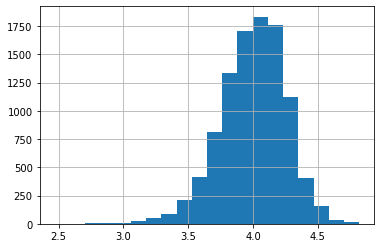

In [46]:
bt_pivot["average_rating"].hist(bins=20)

In [47]:
def custom_round(x, base=5):
    return base * round(x/base)

In [48]:
bt_pivot["average_rating_bin"] = bt_pivot["average_rating"].apply(lambda x: custom_round(x, base=.5))

<AxesSubplot:>

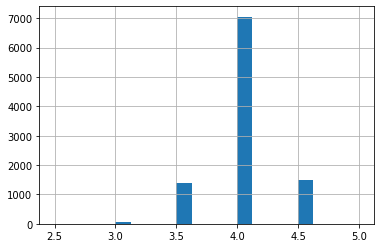

In [49]:
bt_pivot["average_rating_bin"].hist(bins=20)

In [50]:
#bt_test = bt_pivot.loc[:"tag_name"][["ebook", "ebooks", "e-books", "e-book", "average_rating"]]

In [51]:
#bt_test.describe

In [52]:
len(bt_pivot.columns)

98

In [53]:
bt_pivot.drop(labels=["to-buy", "wish-list", "ebook", "ebooks", "e-books", "e-book", "favorite", "favourites", 
                      "favorite-books", "own-it", "owned-books", "books-i-own", 
                      "dnf", "didn-t-finish", "abandoned", "4-stars", "5-stars", 'read-2013', 
                      'read-2014', 'read-2015', 'read-2016', 'read-in-2011', 'read-in-2012', 
                      'read-in-2013', 'read-in-2014', 'read-in-2015', 'read-in-2016', 'read-in-2017', 
                      'audio', 'audio-book', 'audio-books','audiobooks', 'have', 'sci-fi-fantasy', 
                      'science-fiction', "adult-fiction", "my-books", 'historical', 'historical-fiction', 
                      "unfinished", "ya", "i-own", "suspense", "crime", "novels", "contemporary-fiction"
                     ],axis=1, inplace=True)


In [54]:
bt_pivot.columns

Index(['average_rating', 'action', 'adult', 'adventure', 'all-time-favorites',
       'american', 'audible', 'audiobook', 'book-club', 'books', 'borrowed',
       'calibre', 'classics', 'contemporary', 'currently-reading', 'default',
       'did-not-finish', 'drama', 'english', 'family', 'fantasy', 'favorites',
       'fiction', 'finished', 'general-fiction', 'history', 'home-library',
       'humor', 'kindle', 'library', 'library-books', 'literature', 'maybe',
       'my-library', 'mystery', 'non-fiction', 'novel', 'owned', 'paperback',
       're-read', 'reviewed', 'romance', 'sci-fi', 'series',
       'shelfari-favorites', 'thriller', 'to-read', 'to-read-fiction',
       'young-adult', 'intentions', 'read-in', 'average_rating_bin'],
      dtype='object', name='tag_name')

In [55]:
bt_pivot.to_csv("bt.csv")

In [56]:
#fig, ax = plt.subplots(figsize=(4,8))
#sns.boxplot(data = bt_test, x="e-book", y="average_rating")

In [57]:
#plt.matshow(bt_pivot.corr())
#plt.show()

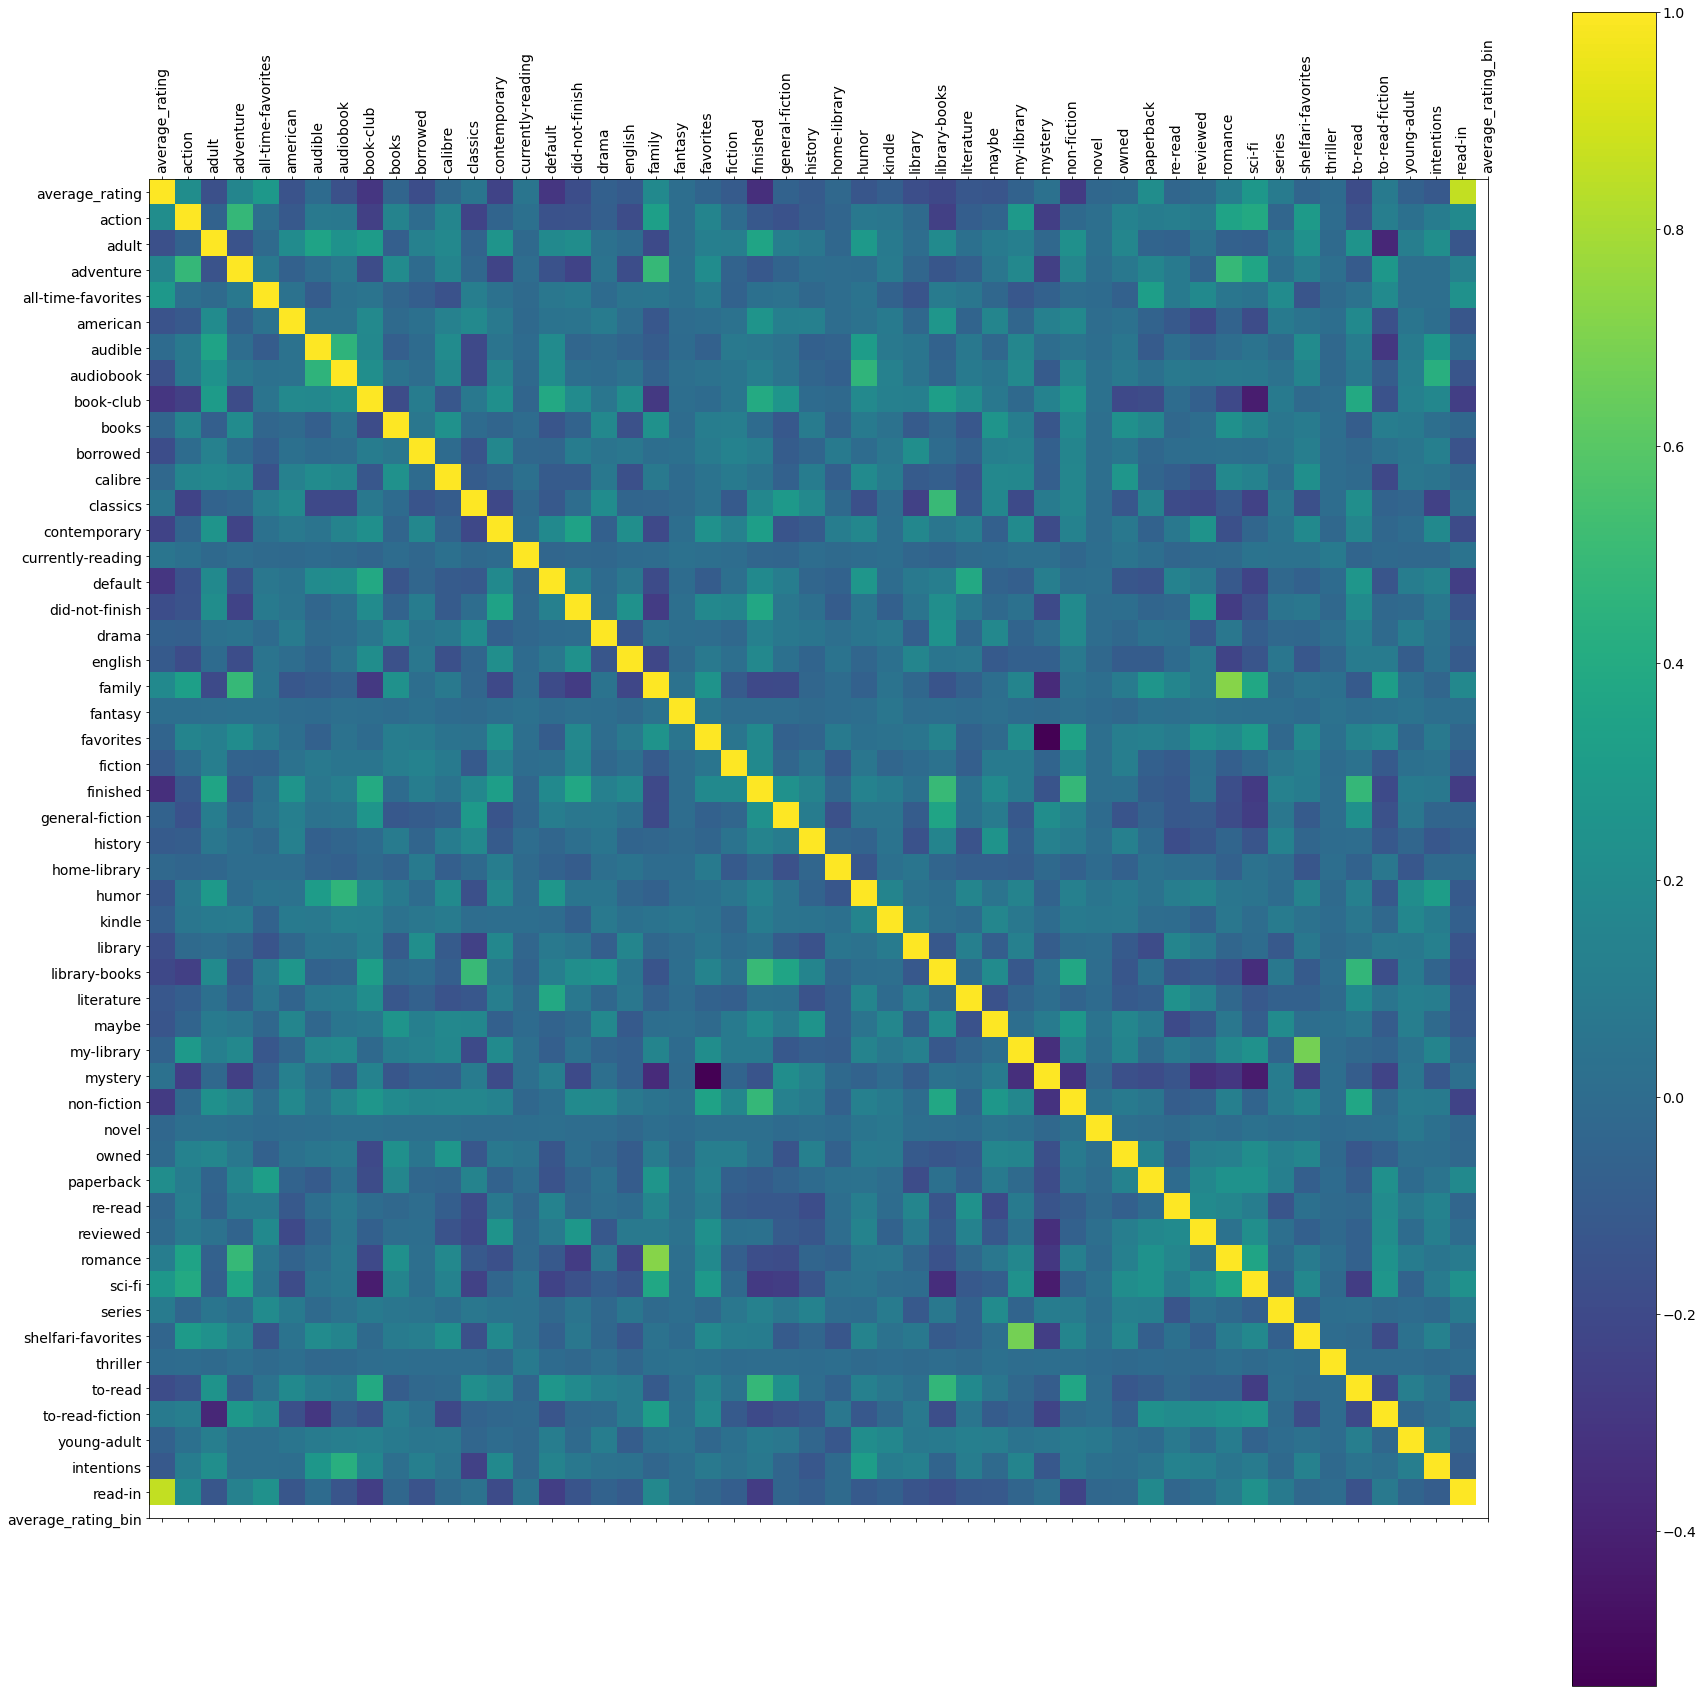

In [58]:
f = plt.figure(figsize=(30, 30))
plt.matshow(bt_pivot.corr(), fignum=f.number)
plt.xticks(range(bt_pivot.shape[1]), bt_pivot.columns, fontsize=14, rotation=90)
plt.yticks(range(bt_pivot.shape[1]), bt_pivot.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [59]:
X = bt_pivot.drop(["average_rating_bin","average_rating"], axis=1)

In [60]:
X.columns

Index(['action', 'adult', 'adventure', 'all-time-favorites', 'american',
       'audible', 'audiobook', 'book-club', 'books', 'borrowed', 'calibre',
       'classics', 'contemporary', 'currently-reading', 'default',
       'did-not-finish', 'drama', 'english', 'family', 'fantasy', 'favorites',
       'fiction', 'finished', 'general-fiction', 'history', 'home-library',
       'humor', 'kindle', 'library', 'library-books', 'literature', 'maybe',
       'my-library', 'mystery', 'non-fiction', 'novel', 'owned', 'paperback',
       're-read', 'reviewed', 'romance', 'sci-fi', 'series',
       'shelfari-favorites', 'thriller', 'to-read', 'to-read-fiction',
       'young-adult', 'intentions', 'read-in'],
      dtype='object', name='tag_name')

# Lasso Regression

In [61]:
y = bt_pivot["average_rating"]

In [62]:
y.describe()

count    10000.000000
mean         4.002191
std          0.254427
min          2.470000
25%          3.850000
50%          4.020000
75%          4.180000
max          4.820000
Name: average_rating, dtype: float64

In [63]:
reg = LassoCV(cv=10, random_state=1234, alphas=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001,0.000001]).fit(X, y)

In [64]:
reg.alpha_

0.0001

In [65]:
np.sum(reg.coef_!=0)

47

In [66]:
np.random.seed(seed=1234)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [68]:
y_pred = reg.predict(X_test)

In [69]:
reg.score(X_train,y_train)

0.41384092657465565

In [70]:
reg.score(X_test, y_test)

0.4228091724548707

In [71]:
pd.Series(reg.coef_, X.columns).sort_values(ascending=False)

tag_name
all-time-favorites    0.150177
series                0.083618
action                0.062618
audible               0.061950
shelfari-favorites    0.058185
non-fiction           0.048988
fantasy               0.046865
classics              0.045357
to-read-fiction       0.041646
currently-reading     0.033281
re-read               0.033162
favorites             0.025093
intentions            0.016521
thriller              0.015169
family                0.012252
history               0.010587
adventure             0.007304
english               0.006815
drama                 0.004789
adult                 0.004243
calibre               0.002884
finished             -0.000000
owned                -0.000000
to-read               0.000000
fiction              -0.002707
kindle               -0.006449
maybe                -0.013552
read-in              -0.013867
mystery              -0.016635
paperback            -0.020544
default              -0.020549
book-club            -0.022319

In [72]:
mse = ((y_pred - y_test) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.04


In [73]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.19


In [74]:
print('The Mean Average Percentage Error of our forecasts is {}'
      .format(np.mean(np.abs((y_test - y_pred) / y_test)) * 100))

The Mean Average Percentage Error of our forecasts is 3.694903821110809


# Random Forest

In [75]:
y = bt_pivot["average_rating_bin"].astype('str')

In [76]:
y.describe()

count     10000
unique        6
top         4.0
freq       7053
Name: average_rating_bin, dtype: object

In [77]:
np.random.seed(seed=1234)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [79]:
cw = {
    '2.5': 100,
    '3.0': 100,
    '3.5': 20,
    '4.0': 1,
    '4.5': 20,
    '5.0': 100    
}

In [80]:
clf = RandomForestClassifier(n_estimators=100, class_weight=cw, random_state=1234)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [81]:
clf

RandomForestClassifier(class_weight={'2.5': 100, '3.0': 100, '3.5': 20,
                                     '4.0': 1, '4.5': 20, '5.0': 100},
                       random_state=1234)

In [82]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.751


In [83]:
print("F1-score:",metrics.f1_score(y_test, y_pred,average='weighted'))

F1-score: 0.7064504983256006


In [84]:
metrics.confusion_matrix(y_test, y_pred)

array([[   0,    0,    1,    0,    0,    0],
       [   0,    0,    6,   10,    0,    0],
       [   0,    1,   78,  323,    1,    0],
       [   0,    0,   41, 2037,   61,    0],
       [   0,    0,    0,  300,  138,    0],
       [   0,    0,    0,    2,    1,    0]])

In [85]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp[:10]

tag_name
all-time-favorites    0.059581
did-not-finish        0.051074
general-fiction       0.046633
novel                 0.035730
book-club             0.033906
series                0.030721
re-read               0.026898
borrowed              0.026492
american              0.024337
contemporary          0.023975
dtype: float64